In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython import display
from IPython.display import HTML
import cv2
import os
import datetime
import argparse

print('Libraries imported')

Libraries imported


In [2]:
# practical function to guarantee repeatability of the experiments
def guarantee_repeatability(seed):
    tf.random.set_seed(seed)
    env.seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.action_space.seed(seed)
    
seed = 0

# Performing random moves

In [3]:
# create environment and return some info
def make_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")
    return env
    
env_name = 'Ant-v2'
print(env_name)
env = make_environment(env_name)

Ant-v2
Action Space: Box(-1.0, 1.0, (8,), float32)
Observation Space: Box(-inf, inf, (111,), float64)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 6000.0


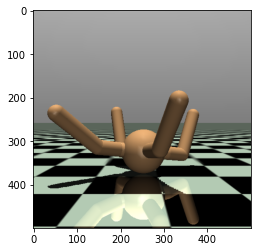

In [4]:
# repeatability
guarantee_repeatability(seed)

env.reset()
# start storing every single frame...
img = plt.imshow(env.render(mode='rgb_array'))
savepath = 'videos/ant_'+str(datetime.datetime.now())+'.png'
plt.savefig(savepath)

num_steps = 100

for t in range(num_steps):
    # ... by updating at every step 
    img.set_data(env.render(mode='rgb_array'))
    savepath = 'videos/ant_'+str(datetime.datetime.now())+'.png'
    plt.savefig(savepath)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # default mode of OpenAI gym
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    #if done:
    #    print("Episode finished after {} timesteps".format(t+1))
    #    break
    
env.close()

In [5]:
# collecting every frame in an array
img_array = []
for filename in sorted(glob.glob('videos/ant_*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    os.remove(filename)
    
video_path = 'videos/ant_init.avi'
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 7.5, size)

# re-creating frames as a video in 'avi' format
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

print('Video saved at ' + video_path)

Video saved at videos/ant_init.avi


# Soft Actor-Critic

### Training

In [3]:
# importing our packages
from sac.sac import SoftActorCritic
from sac.replay_buffer import ReplayBuffer

In [4]:
# create environment and return some info
def make_environment(name):
    env = gym.make(name)
    spec = gym.spec(name)
    print(f"Action Space: {env.action_space}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")
    return env
    
env_name = 'Ant-v2'
print(env_name)
env = make_environment(env_name)

Ant-v2
Action Space: Box(-1.0, 1.0, (8,), float32)
Observation Space: Box(-inf, inf, (111,), float64)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 6000.0


In [5]:
# hyperparameters taken from spinningup
epochs = 200
buf_size = 1000000
steps_per_epoch = 4000
batch_size = 100
start_steps = 10000
update_after = 1000
update_every = 50
save_freq = 1

max_episode_length = env.spec.max_episode_steps # in Ant-v2 it is 1000

state_dim = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
#print(state_dim, action_dim)

# repeatability
guarantee_repeatability(seed)

buf = ReplayBuffer(state_dim, num_actions, buf_size)

sac = SoftActorCritic(state_dim, num_actions)

In [6]:
state = env.reset()
episode_reward = 0
episode_length = 0
# arrays to collect results
episode_lengths = []
episode_rewards = []
actor_losses = []
critic1_losses = []
critic2_losses = []

total_steps = steps_per_epoch * epochs
# main loop over the total steps
for t in range(total_steps):
    # exploration
    if t < start_steps:
        action = env.action_space.sample()
    else:
        action = sac.take_action(state)
    
    # update after a step
    next_state, reward, done, _ = env.step(action)
    episode_reward += reward
    episode_length += 1
    
    # ignore "false positive" done at the end of the maximum length episode
    done = False if episode_length == max_episode_length else done
    
    buf.save(state, action, reward, next_state, done)
    
    state = next_state
    
    # if I'm at the end of an episode, just restart
    if done or (episode_length == max_episode_length):
        episode_lengths.append(episode_length)
        episode_rewards.append(episode_reward)
        
        state = env.reset()
        episode_reward = 0
        episode_length = 0
    
    # ready to learn using sac
    if t >= update_after and t % update_every == 0:
        for j in range(update_every):
            states, next_states, actions, rewards, dones = buf.sample_batch(size=batch_size)
            
            critic1_loss, critic2_loss, actor_loss = sac.train(states, actions, next_states, rewards, dones, batch_size)
            actor_losses.append(actor_loss)
            critic1_losses.append(critic1_loss)
            critic2_losses.append(critic2_loss)
    
    # save model periodically
    if (t+1) % steps_per_epoch == 0:
            epoch = (t+1) // steps_per_epoch

            if (epoch % save_freq == 0) or (epoch == epochs):
                sac.actor.save_weights('models/ant_model')
    if t % 10000 == 0:
        print('Step %d/%d' %(t, total_steps))
        
env.close()

Step 0/800000
Step 10000/800000
Step 20000/800000
Step 30000/800000
Step 40000/800000
Step 50000/800000
Step 60000/800000
Step 70000/800000
Step 80000/800000
Step 90000/800000
Step 100000/800000
Step 110000/800000
Step 120000/800000
Step 130000/800000
Step 140000/800000
Step 150000/800000
Step 160000/800000
Step 170000/800000
Step 180000/800000
Step 190000/800000
Step 200000/800000
Step 210000/800000
Step 220000/800000
Step 230000/800000
Step 240000/800000
Step 250000/800000
Step 260000/800000
Step 270000/800000
Step 280000/800000
Step 290000/800000
Step 300000/800000
Step 310000/800000
Step 320000/800000
Step 330000/800000
Step 340000/800000
Step 350000/800000
Step 360000/800000
Step 370000/800000
Step 380000/800000
Step 390000/800000
Step 400000/800000
Step 410000/800000
Step 420000/800000
Step 430000/800000
Step 440000/800000
Step 450000/800000
Step 460000/800000
Step 470000/800000
Step 480000/800000
Step 490000/800000
Step 500000/800000
Step 510000/800000
Step 520000/800000
Step 53

### Plotting results

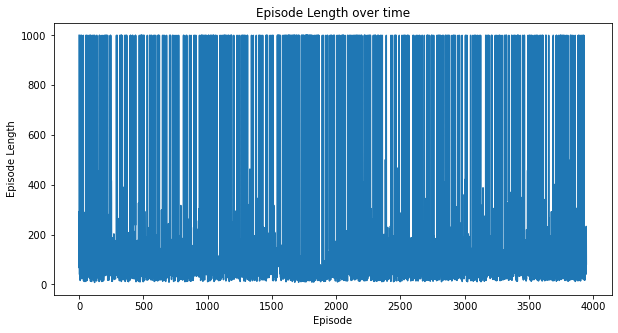

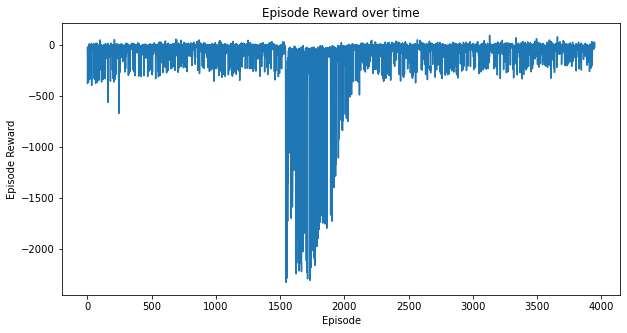

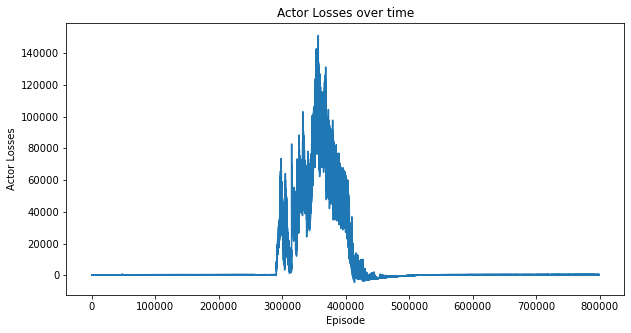

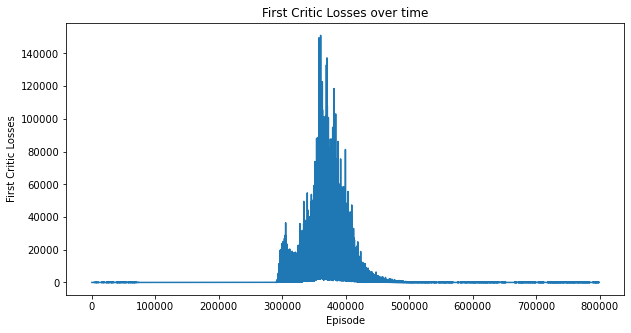

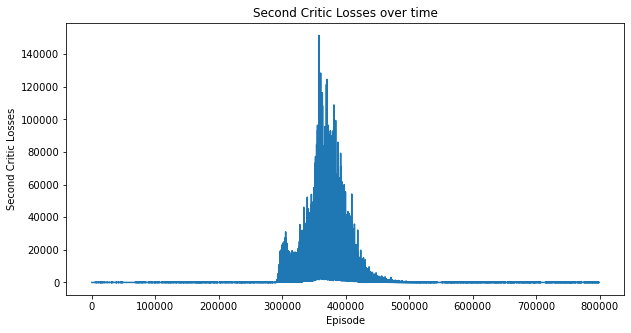

In [7]:
def plot_result(to_plot, xlabel, ylabel, title, savepath):
    fig = plt.figure(figsize=(10, 5))
    plt.plot(to_plot)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(savepath)
    plt.show()

# plotting episode lengths
plot_result(episode_lengths, 'Episode', 'Episode Length',
            'Episode Length over time', 'results/ant_episode_length_over_time')

# plotting episode rewards
plot_result(episode_rewards, 'Episode',
            'Episode Reward', 'Episode Reward over time',
            'results/ant_episode_reward_over_time')

# plot losses
plot_result(actor_losses, 'Episode',
            'Actor Losses', 'Actor Losses over time',
            'results/ant_actor_losses_over_time')
plot_result(critic1_losses, 'Episode',
            'First Critic Losses', 'First Critic Losses over time',
            'results/ant_critic1_losses_over_time')
plot_result(critic2_losses, 'Episode',
            'Second Critic Losses', 'Second Critic Losses over time',
            'results/ant_critic2_losses_over_time')


### Testing

In [8]:
from sac.sac import SoftActorCritic

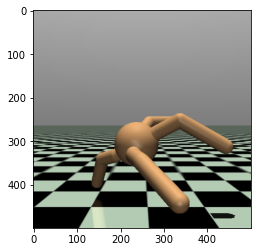

In [24]:
env_name = 'Ant-v2'
env = gym.make(env_name)

state_dim = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
sac = SoftActorCritic(state_dim, num_actions)

# repeatability
guarantee_repeatability(seed)

sac.actor.load_weights('models/ant_model')

max_episode_length = 160
state = env.reset()
# start storing every single frame...
img = plt.imshow(env.render(mode='rgb_array'))
savepath = 'videos/ant_'+str(datetime.datetime.now())+'.png'
plt.savefig(savepath)
done = 0
for _ in range(max_episode_length):
    action = sac.take_action(state)
    next_state, reward, done, info = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    savepath = 'videos/ant_'+str(datetime.datetime.now())+'.png'
    plt.savefig(savepath)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    #if done:
    #    print("Episode finished after {} timesteps".format(t+1))
    #    break
    
    state = next_state

env.close()

In [25]:
# collecting every frame in an array
img_array = []
for filename in sorted(glob.glob('videos/ant_*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
    os.remove(filename)
    
video_path = 'videos/ant_sac.avi'
out = cv2.VideoWriter(video_path,cv2.VideoWriter_fourcc(*'DIVX'), 9.5, size)

# re-creating frames as a video in 'avi' format
for i in range(len(img_array)):
    out.write(img_array[i])
    
out.release()

print('Video saved at ' + video_path)

Video saved at videos/ant_sac.avi
